In [16]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

In [8]:
batch_size_train = 512
batch_size_test = 1000
torch.manual_seed(0); np.random.seed(0)

In [10]:
transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))])

ds_train = torchvision.datasets.MNIST('~/datasets/mnist', train=True, transform=transform)
ds_test = torchvision.datasets.MNIST('~/datasets/mnist', train=False, transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size_train, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size_test, shuffle=True)

In [13]:
x, y = next(iter(dl_train))
x.shape, y.shape

(torch.Size([512, 1, 28, 28]), torch.Size([512]))

In [17]:
def Network():
    return nn.Sequential(
        torch.nn.Conv2d(1, 2, (3,3), padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2,2)),
        torch.nn.Conv2d(2, 4, (3,3), padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2,2)),
        torch.nn.Conv2d(4, 8, (3,3), padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2,2)),
        torch.nn.Conv2d(8, 16, (3,3), padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2,2)),
        torch.nn.Flatten(-3, -1),
        torch.nn.Linear(16, 10)
    )
    
net = Network()
print(x.shape, net(x).shape)

/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([512, 1, 28, 28]) torch.Size([512, 10])


In [26]:
net = Network() 
loss_function = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)

In [60]:
def calc_ds_stats(net, loader):
    losses = []
    accs = []
    for batch_idx, (X_batch, Y_batch) in enumerate(loader):
        Y_batch_pred = net(X_batch)
        loss = loss_function(Y_batch_pred, Y_batch)
        losses.append(loss.item())
        Y_batch_pred_idx = Y_batch_pred.argmax(dim=-1)
        acc = (Y_batch_pred_idx==Y_batch).sum().item()/len(Y_batch)
        accs.append(acc)
    return np.average(losses), np.average(accs)

In [1]:
import numpy as np

In [43]:
def calc_confusion_mat(x, y, yp):
    yp = yp.argmax(dim=-1)
    mat = torch.zeros(10, 10)
    for yi, ypi in zip(y, yp):
        mat[yi, ypi] += 1.
    return mat
def show_confusion_mat(mat):
    mat = mat.cpu().numpy()
    mat = mat/mat.sum()
    plt.imshow(mat)
    plt.colorbar()
    plt.ylabel('Labels'); plt.xlabel('Predicted')
def batch_cossim(a, b=None):
    if b is None:
        b = a[:, None]
    else:
        b = b[:, None]
    a = a[None]
    return torch.cosine_similarity(a, b, dim=-1)
def batch_l2(a, b=None):
    if b is None:
        b = a[:, None]
    else:
        b = b[:, None]
    a = a[None]
    return (a-b).norm(dim=-1)

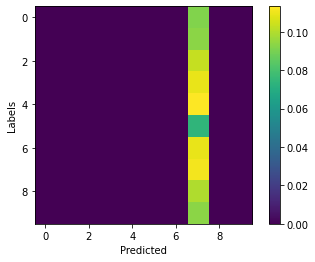

In [39]:
show_confusion_mat(calc_confusion_mat(x, y, net(x)))
plt.show()

In [58]:
device = 'cuda:0'

In [59]:
net = Network().to(device)
loss_function = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)

for _ in range(5):
    loop = tqdm(dl_train)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        yp = net(x)
        loss = batch_cossim(yp).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        loop.set_postfix({'loss': loss.item()})

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

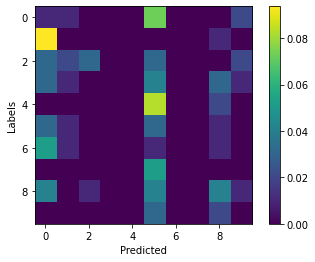

In [60]:
show_confusion_mat(calc_confusion_mat(x, y, net(x)))
plt.show()

In [61]:
calc_ds_stats(net, test_loader)

(2.320777940750122, 0.12009999999999998)

In [62]:
losses = []
for epoch_idx in tqdm(range(5)):
    print(epoch_idx)
    for batch_idx, (X_batch, Y_batch) in tqdm(enumerate(train_loader), total=len(train_loader)):
#         X_batch, Y_batch = X, Y
        Y_batch_pred = net(X_batch)
        loss = loss_function(Y_batch_pred, Y_batch)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        
#     plt.plot(losses);plt.show() 
    print(calc_ds_stats(net, test_loader))


  0%|          | 0/5 [00:00<?, ?it/s]

0


  0%|          | 0/118 [00:00<?, ?it/s]

(0.2664697542786598, 0.9155000000000001)
1


  0%|          | 0/118 [00:00<?, ?it/s]

(0.15614763796329498, 0.9506999999999998)
2


  0%|          | 0/118 [00:00<?, ?it/s]

(0.15456263944506646, 0.9498)
3


  0%|          | 0/118 [00:00<?, ?it/s]

(0.13556534424424171, 0.9571000000000002)
4


  0%|          | 0/118 [00:00<?, ?it/s]

(0.13374587297439575, 0.9549)


In [63]:
calc_ds_stats(net, test_loader)

(0.13374583050608635, 0.9549)

In [104]:
net = Network() 
loss_function = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)

losses = []
for epoch_idx in tqdm(range(1)):
    print(epoch_idx)
    for batch_idx, (X_batch, Y_batch) in tqdm(enumerate(train_loader), total=len(train_loader)):
        Y_batch_pred = net(X_batch)
        
        # change label to the hard prediction
        Y_batch = Y_batch_pred.argmax(dim=-1).detach()
        # change random labels to random numbers
        Y_random = torch.randint(low=0, high=10, size=Y_batch.shape)
        Y_random_mask = torch.rand(size=Y_batch.shape)<0.5
        Y_batch[Y_random_mask] = Y_random[Y_random_mask]
        
        loss = loss_function(Y_batch_pred, Y_batch)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        
#     plt.plot(losses);plt.show() 
    print(calc_ds_stats(net, test_loader))

  0%|          | 0/1 [00:00<?, ?it/s]

0


  0%|          | 0/118 [00:00<?, ?it/s]

(2.35796172618866, 0.1032)


In [109]:
net = Network() 
loss_function = torch.nn.KLDivLoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)

losses = []
for epoch_idx in tqdm(range(1)):
    print(epoch_idx)
    for batch_idx, (X_batch, Y_batch) in tqdm(enumerate(train_loader), total=len(train_loader)):
        Y_batch_pred = net(X_batch)
        
        # change label to the hard prediction
        Y_batch_pred_hard = Y_batch_pred.argmax(dim=-1).detach()
        
        Y_random = torch.randint(low=0, high=10, size=Y_batch.shape)
        Y_random_mask = torch.rand(size=Y_batch.shape)<0.5
        Y_batch_pred_hard[Y_random_mask] = Y_random[Y_random_mask]
        
        
        Y_batch = torch.ones_like(Y_batch_pred)
        Y_batch[torch.arange(len(Y_batch)), Y_batch_pred_hard] += 1.
        Y_batch = Y_batch.softmax(dim=-1)
        
        loss = loss_function(Y_batch_pred.log(), Y_batch)
        

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        
#     plt.plot(losses);plt.show() 
#     print(calc_ds_stats(net, test_loader))

  0%|          | 0/1 [00:00<?, ?it/s]

0


  0%|          | 0/118 [00:00<?, ?it/s]

In [110]:
def test(net, loader):
    idxs_seen = [[] for _ in range(10)]
    for batch_idx, (X_batch, Y_batch) in enumerate(loader):
        Y_batch_pred = net(X_batch)
        Y_batch_pred_idx = Y_batch_pred.argmax(dim=-1)
        
        for i in range(10):
            idxs_seen[i].append(Y_batch_pred_idx[Y_batch==i])
        if batch_idx==10:
            break
    for i in range(10):
        idxs_seen[i] = torch.cat(idxs_seen[i], dim=0)
    return idxs_seen
idxs_seen = test(net, train_loader)

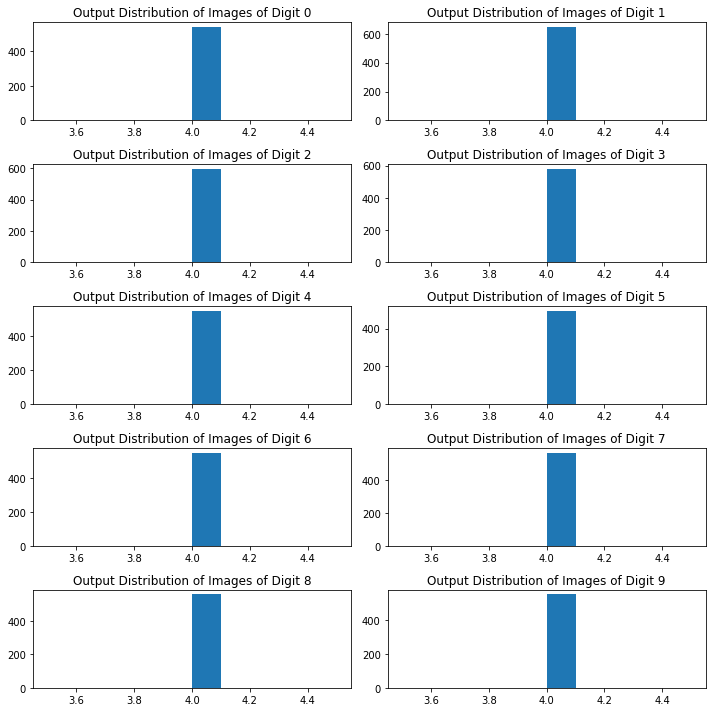

In [111]:
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.hist(idxs_seen[i].numpy())
    plt.title(f'Output Distribution of Images of Digit {i}')
plt.tight_layout()
plt.show()

# Problem
Can we create an MNIST classifier with no labels? 
Instead of using human labels, let us use the most up to date hard prediction of the neural network.

Will this allow it to at least segment the dataset in someway, maybe classifying different classes with different outputs (not necessarily the right index)?

However, this will surely get stuck in a local optima where it classifies EVERYTHING as a 5 or something.

So, can we add random noise to some percentage of the hard predicted labels, forcing it to have diversity in its outputs?

Or can we add random noise to the actual hard prediction distribution??

# Result
No we can't, it always predicts the same class.
